# Tutorial: Introduction to biasing simulations with PLUMED

Getting tutorial files using command line 
```
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/plumed_bias.ipynb
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/xvg_plot.py
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/funcs.py

```

In this tutorial we will learn the basics of how to bias simulations in Gromacs using PLUMED. We will show how to use:
- Restraints 
- Adiabatic bias molecular dynamics (ABMD)
- MetaDynamics

It is expected that you have accomplished plumed_intro.ipynb tutorial.

- Full PLUMED documentation is here https://plumed.github.io/doc-v2.5/user-doc/html/_syntax.html
- For full Gromacs manual, see here http://manual.gromacs.org



## Step 1. Prepare a short alpha-helix in a water box for simulations.
These steps repeat the plumed_intro.ipynb tutorial.
If you have executed that tutorial in this folder before, no need to run this step, the files should be already there.

In [1]:
%%bash --out output --err error
wget https://files.rcsb.org/view/1KX5.pdb

In [1]:
import MDAnalysis as mda
nucl=mda.Universe("1KX5.pdb")

sel_text="(segid B and (resid 24:29 or (resid 23 and name C O CA) or (resid 30 and name N CA)))"
h4helix=nucl.select_atoms(sel_text)


nucl.select_atoms("segid B and resid 23").residues.resnames='ACE'
nucl.select_atoms("segid B and resid 23 and name CA").atoms.names='CH3'
nucl.select_atoms("segid B and resid 30").residues.resnames='NME'
nucl.select_atoms("segid B and resid 30 and name CA").atoms.names='CH3'


nucl.trajectory.remarks=[]
nucl.trajectory.compound=[]
nucl.trajectory.header=['H4 helix']

#print(dimer.atoms.names)
h4helix.write("sys.pdb")

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [5]:
#First get mdp files.
!rm -rf MDProtocols
from funcs import get_files_from_git
prot_url="https://api.github.com/repos/intbio/gmx_protocols/contents/amber_quick"
get_files_from_git(prot_url,'MDProtocols/')

In [47]:
!gmx pdb2gmx -f sys.pdb -o init.pdb -p topol.top -water tip3p -ff amber99sb-ildn >/dev/null 2>&1
#Comment out >/dev/null 2>&1 if you see errors or to see output of the command
#Same in all commands below, the output is supressed to save space

In [48]:
#First put a system in a periodic box, with 1 nm distance to the walls (-d), centered in the box (-c)
!gmx editconf -d 1 -c -f init.pdb -o init_box.pdb >/dev/null 2>&1

In [49]:
#Now to the solvation, note, the topology file will be updated to reflect the added water molecules.
!gmx solvate -cp init_box.pdb -cs spc216.gro -o init_solv.pdb -p topol.top >/dev/null 2>&1

In [51]:
!gmx grompp -f MDProtocols/ions.mdp -c init_solv.pdb -p topol.top -o ions.tpr -maxwarn 1 >/dev/null 2>&1

In [52]:
%%bash
gmx genion -s ions.tpr -o init_solv_ions.pdb -p topol.top -conc 0.150 -neutral <<! >/dev/null 2>&1
SOL
!

The `grompp` comand packs topology together with mdp file into a .tpr file - the sole file needed to start minimization/simulation.
See details here http://manual.gromacs.org/documentation/current/onlinehelp/gmx-grompp.html

In [54]:
!gmx grompp -f MDProtocols/minim.mdp -c init_solv_ions.pdb -p topol.top -o minim.tpr -r init_solv_ions.pdb >/dev/null 2>&1

Now let's run the minimization, this may take a while ...

In [55]:
!gmx mdrun -nt 10 -deffnm minim >/dev/null 2>&1 # nt is the number of threads, choose less than the number of CPUs you have

In [56]:
!gmx grompp -f MDProtocols/equil.mdp -c minim.gro -p topol.top -o equil.tpr -r init_solv_ions.pdb >/dev/null 2>&1

In [59]:
!gmx mdrun -nt 10 -deffnm equil >/dev/null 2>&1  # nt is the number of threads, choose less than the number of CPUs you have

Finally, let's prepare the 0.1 ns production file.

In [20]:
!gmx grompp -f MDProtocols/prod.mdp -c equil.gro -p topol.top -o prod.tpr -r init_solv_ions.pdb >/dev/null 2>&1

## Step 2. Now we are ready to explore PLUMED biasing functionality
- Invoking GROMACS to use PLUMED is as ```gmx mdrun -plumed plumed.dat```
- We'll need to make a plumed.dat file with commands for PLUMED

## Step 2.1. Simple restraints
We will restraint the ends of the alpha-helix.
- https://plumed.github.io/doc-v2.5/user-doc/html/_r_e_s_t_r_a_i_n_t.html

By default the PLUMED inputs and outputs quantities in the following units:

Energy - kJ/mol
Length - nanometers
Time - picoseconds

We will restraint the distance between atoms 9 and 78 at 2.0 nm, with harmonic constant k of 150 kJ/mol.
We will print the energy of the restraint.

d1: DISTANCE ATOMS=9,78
res1: RESTRAINT ARG=d1 AT=2.0 KAPPA=150.0
PRINT ARG=d1,res1.bias,res1.force2 FILE=colvar.dat STRIDE=10
Labels found: ['time', 'd1', 'res1.bias', 'res1.force2']


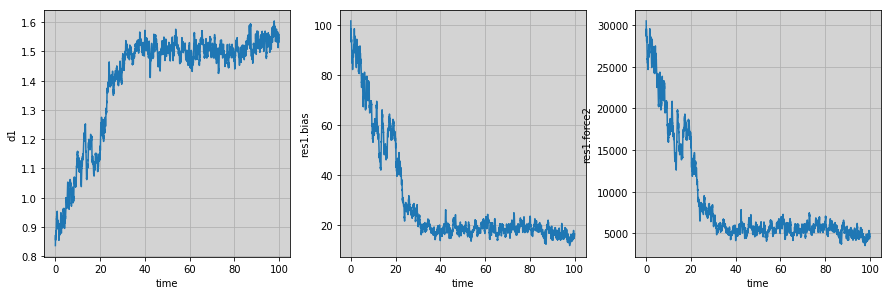

In [11]:
!echo "d1: DISTANCE ATOMS=9,78" >plumed.dat
!echo "res1: RESTRAINT ARG=d1 AT=2.0 KAPPA=150.0" >>plumed.dat
!echo "PRINT ARG=d1,res1.bias,res1.force2 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

In [9]:
#here is the file that we get 
!head colvar.dat

#! FIELDS time d1 res1.bias res1.force2
 0.000000 0.835698 2.024630 607.389015
 0.020000 0.846894 1.758104 527.431140
 0.040000 0.857384 1.525446 457.633733
 0.060000 0.866652 1.333621 400.086447
 0.080000 0.848460 1.722325 516.697644
 0.100000 0.843736 1.831380 549.413995
 0.120000 0.850392 1.678692 503.607730
 0.140000 0.858121 1.509730 452.919150
 0.160000 0.845394 1.792719 537.815665


In [13]:
import nglview as nv
import MDAnalysis as mda
MD=mda.Universe('init_solv_ions.pdb','prod.xtc')
nv.show_mdanalysis(MD)

NGLWidget(count=11)

## Step 2.2. Adiabatic bias molecular dynamics (ABMD)
We'll add a a ratchet-and-pawl like restraint on the ends of the alpha-helix.
- https://plumed.github.io/doc-v2.5/user-doc/html/_a_b_m_d.html
- We'll set KAPPA to 150 kJ/mol/nm^2 . Means, 1 A deviation will be penalized with 

The formulas for biasing potential in ABMD are as follows:
$$V(\rho(t)) = \left \{ \begin{array}{ll} \frac{K}{2}\left(\rho(t)-\rho_m(t)\right)^2, &\rho(t)>\rho_m(t)\\ 0, & \rho(t)\le\rho_m(t), \end{array} \right .    $$
where
$$\rho(t)=\left(CV(t)-TO\right)^2$$
and $$\rho_m(t)=\min_{0\le\tau\le t}\rho(\tau)+\eta(t)$$
Let's plot it

(0, 15000)

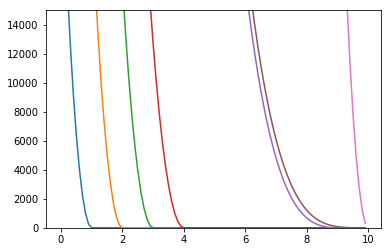

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x=np.arange(0,10,0.1)
kappa=150
def abmd_pot(x,x_to,x_now):
    rho_min=(x_now-x_to)**2
    rho=(x-x_to)**2
    return list(map(lambda t: kappa/2*(t-rho_min)**2 if t>rho_min else 0 ,rho))
plt.plot(x,abmd_pot(x,10,1))
plt.plot(x,abmd_pot(x,10,2))
plt.plot(x,abmd_pot(x,10,3))
plt.plot(x,abmd_pot(x,10,4))
plt.plot(x,abmd_pot(x,10,9))
plt.plot(x,abmd_pot(x,10,10))
plt.plot(x,abmd_pot(x,20,10))
plt.ylim(0,kappa*100)

- We see that the biasing wall shape is ~x**4 in nature
- The wall becomes less steep as we move towards the target value of CV
- So the ratchet potential relaxes as we approach the target value
- It is important to do some modeling to chose the right parameters for ABMD that will select the needed behavior

- Imagine we need to bring CV from 0 nm to 10 nm within 5 A of 10 nm, and set the target at 10 nm. What K to choose?
- Means we'll want the penalty at 10 nm to be several kT (kT=2.4 kJ/mol, so let say 10 kJ/mol) if system tries to move backward for 5 A.
$$K/2*((9.5-10)^2-(0-0)^2)^2=10 kJ/mol$$

In [2]:
K=10*2/((9.5-10)**2-(10-10)**2)**2
K

320.0

But we will however get large energies at 0 nm, if deviation is around 5 A. And the simulatin might be unstable.

In [83]:
Estart=K/2*((-0.5-10)**2-(0-10)**2)**2
Estart

16810.0

In [84]:
#This is the difference in potential steepness at the start and end of the CV.
Estart/10

1681.0

In [87]:
#To mitigate this we can move the target value of CV further if we can allow for it.
#The difference in steepness then will be
xtarget=12
Estart=K/2*((-0.5-xtarget)**2-(0-xtarget)**2)**2
Eend=K/2*((9.5-xtarget)**2-(10-xtarget)**2)**2
Estart/Eend

29.641975308641975

d1: DISTANCE ATOMS=9,78
abmd: ABMD ARG=d1 TO=2.0 KAPPA=150.0
PRINT ARG=d1,abmd.bias,abmd.d1_min FILE=colvar.dat STRIDE=10
Labels found: ['time', 'd1', 'abmd.bias', 'abmd.d1_min']


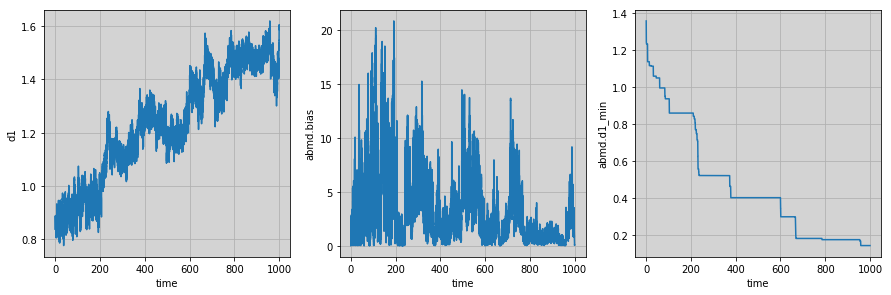

In [21]:
!echo "d1: DISTANCE ATOMS=9,78" >plumed.dat
!echo "abmd: ABMD ARG=d1 TO=2.0 KAPPA=150.0" >>plumed.dat
!echo "PRINT ARG=d1,abmd.bias,abmd.d1_min FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

In [22]:
import nglview as nv
import MDAnalysis as mda
MD=mda.Universe('init_solv_ions.pdb','prod.xtc')
nv.show_mdanalysis(MD)

NGLWidget(count=101)

## Step 2.3. MetaDynamics
A metadynamics run
- https://plumed.github.io/doc-v2.5/user-doc/html/_m_e_t_a_d.html


d1: DISTANCE ATOMS=9,78
res: METAD ARG=d1 SIGMA=0.2 HEIGHT=0.3 PACE=500
PRINT ARG=d1,res.bias,res.work FILE=colvar.dat STRIDE=10
Labels found: ['time', 'd1', 'res.bias', 'res.work']


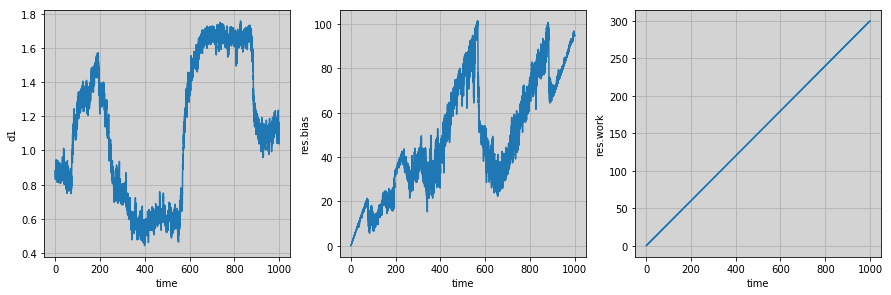

In [23]:
!echo "d1: DISTANCE ATOMS=9,78" >plumed.dat
!echo "res: METAD ARG=d1 SIGMA=0.2 HEIGHT=0.3 PACE=500" >>plumed.dat
!echo "PRINT ARG=d1,res.bias,res.work FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

In [25]:
import nglview as nv
import MDAnalysis as mda
MD=mda.Universe('init_solv_ions.pdb','prod.xtc')
nv.show_mdanalysis(MD)

NGLWidget(count=101)

In [83]:
## Other commands

In [26]:
# Auxilary
# Clear files
!rm \#*
!rm bck*